In [1]:
from pathlib import Path
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import TargetEncoder
from sklearn.metrics import f1_score,recall_score,precision_score,confusion_matrix

from sklearn.metrics import classification_report


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [55]:
train_date = pd.read_csv('C:/Users/wgkdj/smbc_comp/input/train.csv')
test_date = pd.read_csv('C:/Users/wgkdj/smbc_comp/input/test.csv')
sub_df = pd.read_csv('C:/Users/wgkdj/smbc_comp/input/sample_submission.csv',header=None)
sub_df.columns = ["index", "health"]
row_data = pd.read_csv('C:/Users/wgkdj/work12_07/newrows.csv')

In [92]:
train_date['steward'].unique()

array([nan, '3or4', '1or2', '4orMore'], dtype=object)

In [93]:
train_date.isnull().sum()

Unnamed: 0        0
created_at        0
tree_dbh          0
curb_loc          0
health            0
steward       14883
guards        14943
sidewalk          0
user_type         0
problems      12243
spc_common        0
spc_latin         0
nta               0
nta_name          0
borocode          0
boro_ct           0
boroname          0
zip_city          0
cb_num            0
st_senate         0
st_assem          0
cncldist          0
dtype: int64

In [31]:
train_date['nta'].value_counts()

nta
SI54    368
SI11    359
BK82    326
BK45    306
SI32    306
SI01    300
MN12    292
QN46    285
MN40    281
QN17    267
SI05    260
QN49    246
QN21    235
QN45    222
BK37    220
BK42    216
SI36    214
QN15    213
BK31    213
BK75    213
QN42    211
SI48    211
SI07    206
QN20    195
SI35    191
SI25    191
QN55    190
BK33    189
QN43    186
QN03    185
BK61    180
QN57    178
SI28    175
SI24    174
QN37    165
BX09    165
BK32    165
QN05    165
BK35    164
QN51    163
SI22    161
QN44    161
QN38    159
BX52    154
BK83    152
MN25    151
QN31    150
SI37    149
BK58    144
BK17    143
QN08    139
SI12    138
QN19    137
QN66    134
BK76    131
SI45    128
BK69    127
QN48    125
BX27    125
BK85    123
MN24    122
BX36    122
BK88    121
QN01    120
SI08    120
BX10    119
BK79    119
QN56    118
BK90    117
QN23    116
MN34    114
QN06    114
BK72    113
MN23    111
QN72    111
BX31    108
QN34    105
QN30    104
BK77    104
QN10    103
BX59    101
QN28    101
MN15     98


In [56]:
class PreProcessTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        X['created_at'] = pd.to_datetime(X['created_at'])
        X['created_at_year'] = X['created_at'].dt.year
        X['created_at_month'] = X['created_at'].dt.month
        X['created_at_day'] = X['created_at'].dt.day
        X['problems'].fillna(' ', inplace=True)
        X['problems'] = X['problems'].astype('category')
        problem = ["Stones", "BranchLights", "BranchOther", "RootOther", "TrunkOther", "WiresRope", "MetalGrates", "TrunkLights"]
        for substring in problem:
            X[substring] = X['problems'].apply(lambda row: 1 if (pd.notnull(row) and substring in row) else 0)
        X['int_steward'] = X['steward'].replace({'1or2': 1, '3or4': 2, '4orMore': 3})
        X['null_problems'] = X['problems'].apply(lambda x: 1 if pd.isnull(x) else 0)
        X['weekdays'] = X['created_at'].dt.day_name()
        X['status'] = 0
        X.loc[X['steward'].isnull() & X['guards'].isnull(), 'status'] = 1
        X['status'] = X['status'].astype('str')
        X['nta_prefix'] = X['nta'].str[:2]
        X['nta_suffix'] = X['nta'].str[2:].astype('int')
        return X

class OriginalTransformer(TransformerMixin, BaseEstimator):
    """数値特徴はそのまま、カテゴリ特徴はcategory型に変換"""

    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()

        # 数値変数
        X_new[self.numeric_cols] = X_new[self.numeric_cols].astype("float32")

        # カテゴリ変数
        X_new[self.categorical_cols] = X_new[self.categorical_cols].astype("category")
        
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self):
        return self.numeric_cols + self.categorical_cols
class AggTransformer(TransformerMixin, BaseEstimator):
    """集約特徴量"""

    def __init__(self, key, numeric_cols, agg_func: dict):
        self.key = key
        self.numeric_cols = numeric_cols
        self.agg_func = agg_func

    def fit(self, X, y=None):
        X = X.copy()
        X[self.key] = X[self.key].astype("category")
        self.agg_df = X.groupby(self.key)[self.numeric_cols].agg(self.agg_func)
        self.agg_df.columns = [f"{col}_{func}" for col, func in self.agg_df.columns.tolist()]

        return self

    def transform(self, X):
        X_new = pd.merge(X, self.agg_df, on=self.key, how="left")
        return X_new[self.get_feature_names_out()]

    def get_feature_names_out(self, input_features=None):
        return self.agg_df.columns.tolist()

In [57]:
import category_encoders as ce



train_date = train_date[~train_date['spc_common'].isin(['Himalayan cedar', 'Chinese chestnut'])]

numeric_cols = [
    'tree_dbh',
    'borocode',
    'boro_ct',
    'cb_num',
    'st_senate',
    'st_assem',
    'cncldist',
    'created_at_year',
    'created_at_month',
    'created_at_day',
    'int_steward',
    #'nta_suffix',
]
categorical_cols = [
    'curb_loc',
    'guards',
    'sidewalk',
    'user_type',
    #'problems',
    'Stones',
    'BranchLights',
    'BranchOther',
    'RootOther',
    'TrunkOther',
    'WiresRope',
    'MetalGrates',
    'TrunkLights',
    'status',
    'null_problems',
    #'weekdays',
]

# ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        (
            "ori",
            OriginalTransformer(numeric_cols, categorical_cols),
            numeric_cols + categorical_cols
        ),
        (
            "tgt",
            ce.TargetEncoder(cols=[ 'steward', 'guards','user_type', 'problems',
                                   'spc_common', 'nta','zip_city']),
            [ 'steward', 'guards', 'user_type','problems',
             'spc_common','nta','zip_city']
        ),
    ],
    verbose=True
)

# Pipeline
ct.set_output(transform="pandas")
pipe = Pipeline(
    steps=[
        ("preprocess", PreProcessTransformer()),
        ('ct', ct),
    ]
)
# Fit and transform

train_feat_df = pipe.fit_transform(train_date, train_date['health'])
test_feat_df = pipe.transform(test_date)


[ColumnTransformer] ........... (1 of 2) Processing ori, total=   0.0s
[ColumnTransformer] ........... (2 of 2) Processing tgt, total=   0.2s


In [98]:
train_feat_df['ori__BranchLights'].value_counts()

ori__BranchLights
0    17345
1     2635
Name: count, dtype: int64

In [99]:
train_feat_df['ori__BranchLights'].isnull().sum()

0

In [100]:
train_feat_df.head()

,ori__tree_dbh,ori__borocode,ori__boro_ct,ori__cb_num,ori__st_senate,ori__st_assem,ori__cncldist,ori__created_at_year,ori__created_at_month,ori__created_at_day,ori__int_steward,ori__null_problems,ori__curb_loc,ori__guards,ori__sidewalk,ori__user_type,ori__Stones,ori__BranchLights,ori__BranchOther,ori__RootOther,ori__TrunkOther,ori__WiresRope,ori__MetalGrates,ori__TrunkLights,tgt__steward,tgt__guards,tgt__user_type,tgt__problems,tgt__spc_common,tgt__nta,tgt__boroname,tgt__zip_city
0,14.0,4.0,4152901.0,411.0,11.0,25.0,23.0,2015.0,6.0,29.0,NaN,0.0,OnCurb,NaN,Damage,Volunteer,0,0,0,0,0,0,0,0,0.864189,0.870272,0.849647,0.870098,0.815192,0.905405,0.858186,0.905405
1,5.0,2.0,2039901.0,207.0,33.0,78.0,15.0,2016.0,9.0,21.0,2.0,0.0,OnCurb,Helpful,NoDamage,Volunteer,0,0,0,0,0,0,0,0,0.857275,0.824110,0.849647,0.870098,0.896296,0.863806,0.854626,0.854626
2,26.0,5.0,5017011.0,503.0,24.0,62.0,51.0,2015.0,9.0,13.0,NaN,0.0,OnCurb,NaN,NoDamage,Volunteer,1,1,0,0,0,0,0,0,0.864189,0.870272,0.849647,0.809711,0.815192,0.836667,0.860932,0.860932
3,15.0,5.0,5024401.0,503.0,24.0,62.0,51.0,2016.0,5.0,9.0,NaN,0.0,OnCurb,NaN,Damage,NYC Parks Staff,0,0,0,0,0,0,0,0,0.864189,0.870272,0.862954,0.870098,0.852031,0.888579,0.860932,0.860932
4,23.0,1.0,1022102.0,110.0,30.0,70.0,9.0,2016.0,6.0,24.0,NaN,0.0,OnCurb,NaN,NoDamage,Volunteer,1,0,0,0,0,0,0,0,0.864189,0.870272,0.849647,0.826048,0.839070,0.785010,0.860577,0.858844


In [44]:


def plot_confusion_matrix(test_y, pred_y, class_names, normalize=False, figsize=(8, 6)):
    cm = confusion_matrix(test_y, pred_y)
    classes = class_names
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=figsize)  # Add the figsize parameter here
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        ylabel='True label\n',
        xlabel='\nPredicted label'
    )
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center")
    fig.tight_layout()
    return ax

# Example usage:
# plot_confusion_matrix(test_y, pred_y, class_names, normalize=False, figsize=(6, 4))


In [45]:
def get_statified_cv(df,y,n_fold=5):
    kf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=2021)
    return list(kf.split(df,y))
def get_cv(df, n_fold=6):
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=71)
    return list(kf.split(df))

def fit_lgbm(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    score_list_all = []
    models = []
    n_records = len(X)
    recall_list = []
    precision_list = []

    oof = np.zeros((n_records,), dtype=np.int32)
    for fold_, (train_index, valid_index) in enumerate(cv):
        train_x = X.iloc[train_index]
        valid_x = X.iloc[valid_index]
        train_y = y.iloc[train_index]
        valid_y = y.iloc[valid_index]
        gbm = lgb.LGBMClassifier(**params)
        gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                callbacks=[lgb.early_stopping(100, verbose=verbose)], )
        pred_i = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
        oof[valid_index] = pred_i
        score_list_all.append(round(f1_score(valid_y, pred_i, average='macro'), 4))
        recall_list.append(round(recall_score(valid_y, pred_i,average='macro'), 4))
        precision_list.append(round(precision_score(valid_y, pred_i,average='macro'), 4))
        models.append(gbm)  # Store the trained model in the list
        print(f'fold{fold_ + 1} end\n')
        print(score_list_all, 'f1_score', np.mean(score_list_all))
        print(precision_list, 'precision', np.mean(precision_list))
        print(recall_list, 'recall', np.mean(recall_list))
        plot_confusion_matrix(valid_y, pred_i,[0,1,2])
    return models, oof, gbm
def fit_lgbm2(X, y, cv, categorical_cols: list = None, params: dict = None, verbose: int = 50):
    score_list_all = []
    models = []
    n_records = len(X)
    recall_list = []
    precision_list = []
    recall_list_all=[]
    precision_list_all=[]
    all_valid_y = []  # Accumulate true labels
    all_pred_i = []   # Accumulate predicted labels
    oof = np.zeros((n_records,), dtype=np.int32)
    for fold_, (train_index, valid_index) in enumerate(cv):
        train_x = X.iloc[train_index]
        valid_x = X.iloc[valid_index]
        train_y = y.iloc[train_index]
        valid_y = y.iloc[valid_index]
        gbm = lgb.LGBMClassifier(**params)
        gbm.fit(train_x, train_y, eval_set=[(valid_x, valid_y)],
                callbacks=[lgb.early_stopping(100, verbose=verbose)], )
        pred_i = gbm.predict(valid_x, num_iteration=gbm.best_iteration_)
        oof[valid_index] = pred_i

        all_valid_y.extend(valid_y)  # Accumulate true labels across folds
        all_pred_i.extend(pred_i)   # Accumulate predicted labels across folds
        score_list_all.append(round(f1_score(valid_y, pred_i, average='macro'), 4))
        recall_list.append([round(recall_score(valid_y, pred_i, average='macro', labels=[label]), 4) for label in [0, 1, 2]])
        precision_list.append([round(precision_score(valid_y, pred_i, average='macro', labels=[label]), 4) for label in [0, 1, 2]])
        recall_list_all.append(round(recall_score(valid_y, pred_i,average='macro'), 4))
        precision_list_all.append(round(precision_score(valid_y, pred_i,average='macro'), 4))
        models.append(gbm)  # トレーニング済みモデルをリストに格納
        print(f'fold{fold_ + 1} end\n')
        print(score_list_all, 'f1_score', np.mean(score_list_all))
        variance_f1_score = np.var(score_list_all)
        print(variance_f1_score)
        print(recall_list_all,'recall_score_all',np.mean(recall_list_all))
        print(precision_list_all,'precision_score_all',np.mean(precision_list_all))
        #print('recall',recall_list, '\nrecall_avg', np.mean(recall_list, axis=0))
        #print('precision',precision_list, '\nprecision_avg', np.mean(precision_list, axis=0))
        #plot_confusion_matrix(valid_y, pred_i, [0, 1, 2])
    plot_confusion_matrix(all_valid_y, all_pred_i,[0, 1, 2])  # Assuming 0 to 9 are your class labels
    plt.show()
    return models, oof, gbm
def visualize_oof_gt(oof, gt):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(oof, gt, alpha=0.5)
    gt_max = gt.max()
    ax.plot(np.arange(0, gt_max), np.arange(0, gt_max), color="red", alpha=0.5, linestyle="--")
    ax.set_xlabel("Out Of Fold")
    ax.set_ylabel("Ground Truth")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax


def visualize_oof_pred(oof, pred):
    fig, ax = plt.subplots(figsize=(8, 6))

    bins = 100
    ax.hist(pred, bins=bins, density=True, alpha=0.5, label="Test")
    ax.hist(oof, bins=bins, density=True, alpha=0.5, label="OutOfFold")
    ax.grid()
    ax.legend()
    fig.tight_layout()

    fig, ax
def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["feature_importance"] = model.feature_importances_
        _df["column"] = feat_train_df.columns
        _df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = (
        feature_importance_df.groupby("column")
        .sum()[["feature_importance"]]
        .sort_values("feature_importance", ascending=False)
        .index[:50]
    )

    fig, ax = plt.subplots(figsize=(12, max(6, len(order) * 0.25)))
    sns.boxenplot(
        data=feature_importance_df,
        x="feature_importance",
        y="column",
        order=order,
        ax=ax,
        palette="viridis",
        orient="h",
    )
    ax.tick_params(axis="x", rotation=90)
    ax.set_title("Importance")
    ax.grid()
    fig.tight_layout()
    return fig, ax



[(array([    0,     1,     2, ..., 19977, 19978, 19979]), array([    4,     8,     9, ..., 19971, 19972, 19973])), (array([    0,     1,     2, ..., 19975, 19978, 19979]), array([   13,    17,    32, ..., 19970, 19976, 19977])), (array([    0,     1,     2, ..., 19976, 19977, 19978]), array([   10,    11,    12, ..., 19959, 19965, 19979])), (array([    1,     2,     3, ..., 19976, 19977, 19979]), array([    0,     6,     7, ..., 19963, 19974, 19978])), (array([    0,     4,     6, ..., 19977, 19978, 19979]), array([    1,     2,     3, ..., 19967, 19969, 19975]))]
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.1 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.1 will be ignored. C

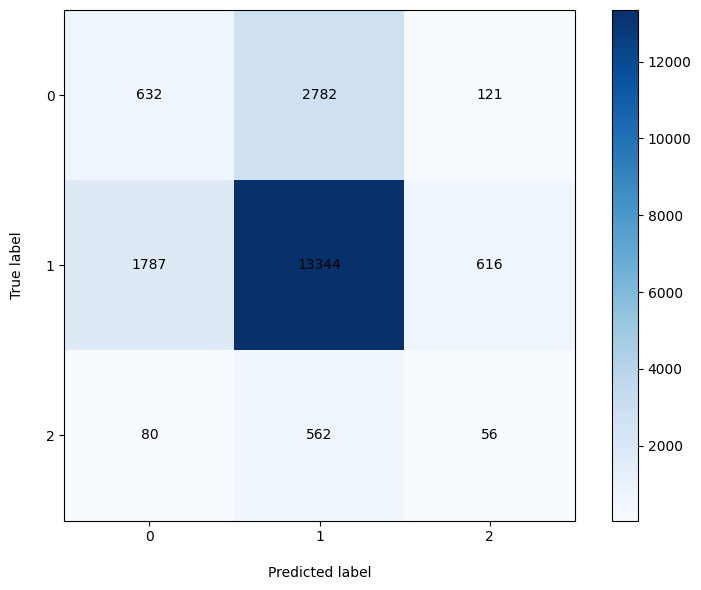

In [58]:
n_fold = 5
lgbm_params = {
    'eta':0.1,
    'n_estimators':100,
    'objective': 'multiclass',
    'num_class': 3,  # クラスの数を指定
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'class_weight': {0: 3, 1: 1, 2: 12},
    #'importance_type' : 'gain'
    #'device_type' :'gpu'
    #1以外の数値を上げるとreal１がより当該ラベルに落ちるようになる
    
}

feat_cat_cols = train_feat_df.select_dtypes(include="category").columns.tolist()

cv = get_statified_cv(df=train_feat_df,y=train_date['health'], n_fold=5)
#cv = get_cv(df=train_feat_df,n_fold=5)
print(cv)
# training

models,oof,gbm = fit_lgbm2(
    train_feat_df,
    y=train_date["health"],
    categorical_cols=[],
    params=lgbm_params,
    cv=cv,
    verbose=False,
)

0.3464, 0.3764, 0.3528, 0.3827, 0.3753] f1_score 0.36672000000000005
0.00020586960000000014
[0.3468, 0.375, 0.3531, 0.379, 0.3762] recall_score_all 0.36601999999999996
[0.3509, 0.3825, 0.3597, 0.3927, 0.3779] precision_score_all 0.37274

In [11]:
train_feat_df['ori__status'].value_counts()

ori__status
1.0    13007
0.0     6977
Name: count, dtype: int64

(<Figure size 1200x825 with 1 Axes>,
 <Axes: title={'center': 'Importance'}, xlabel='feature_importance', ylabel='column'>)

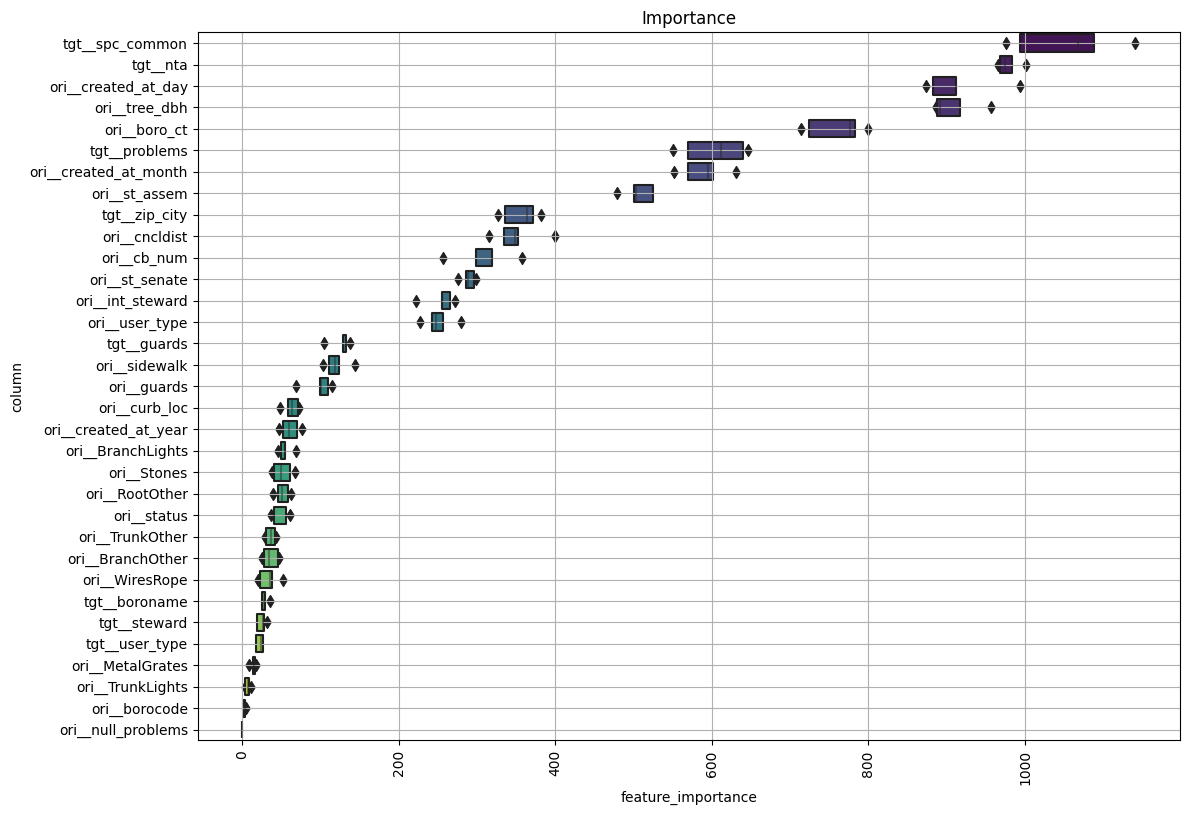

In [9]:
visualize_importance(models,train_feat_df)

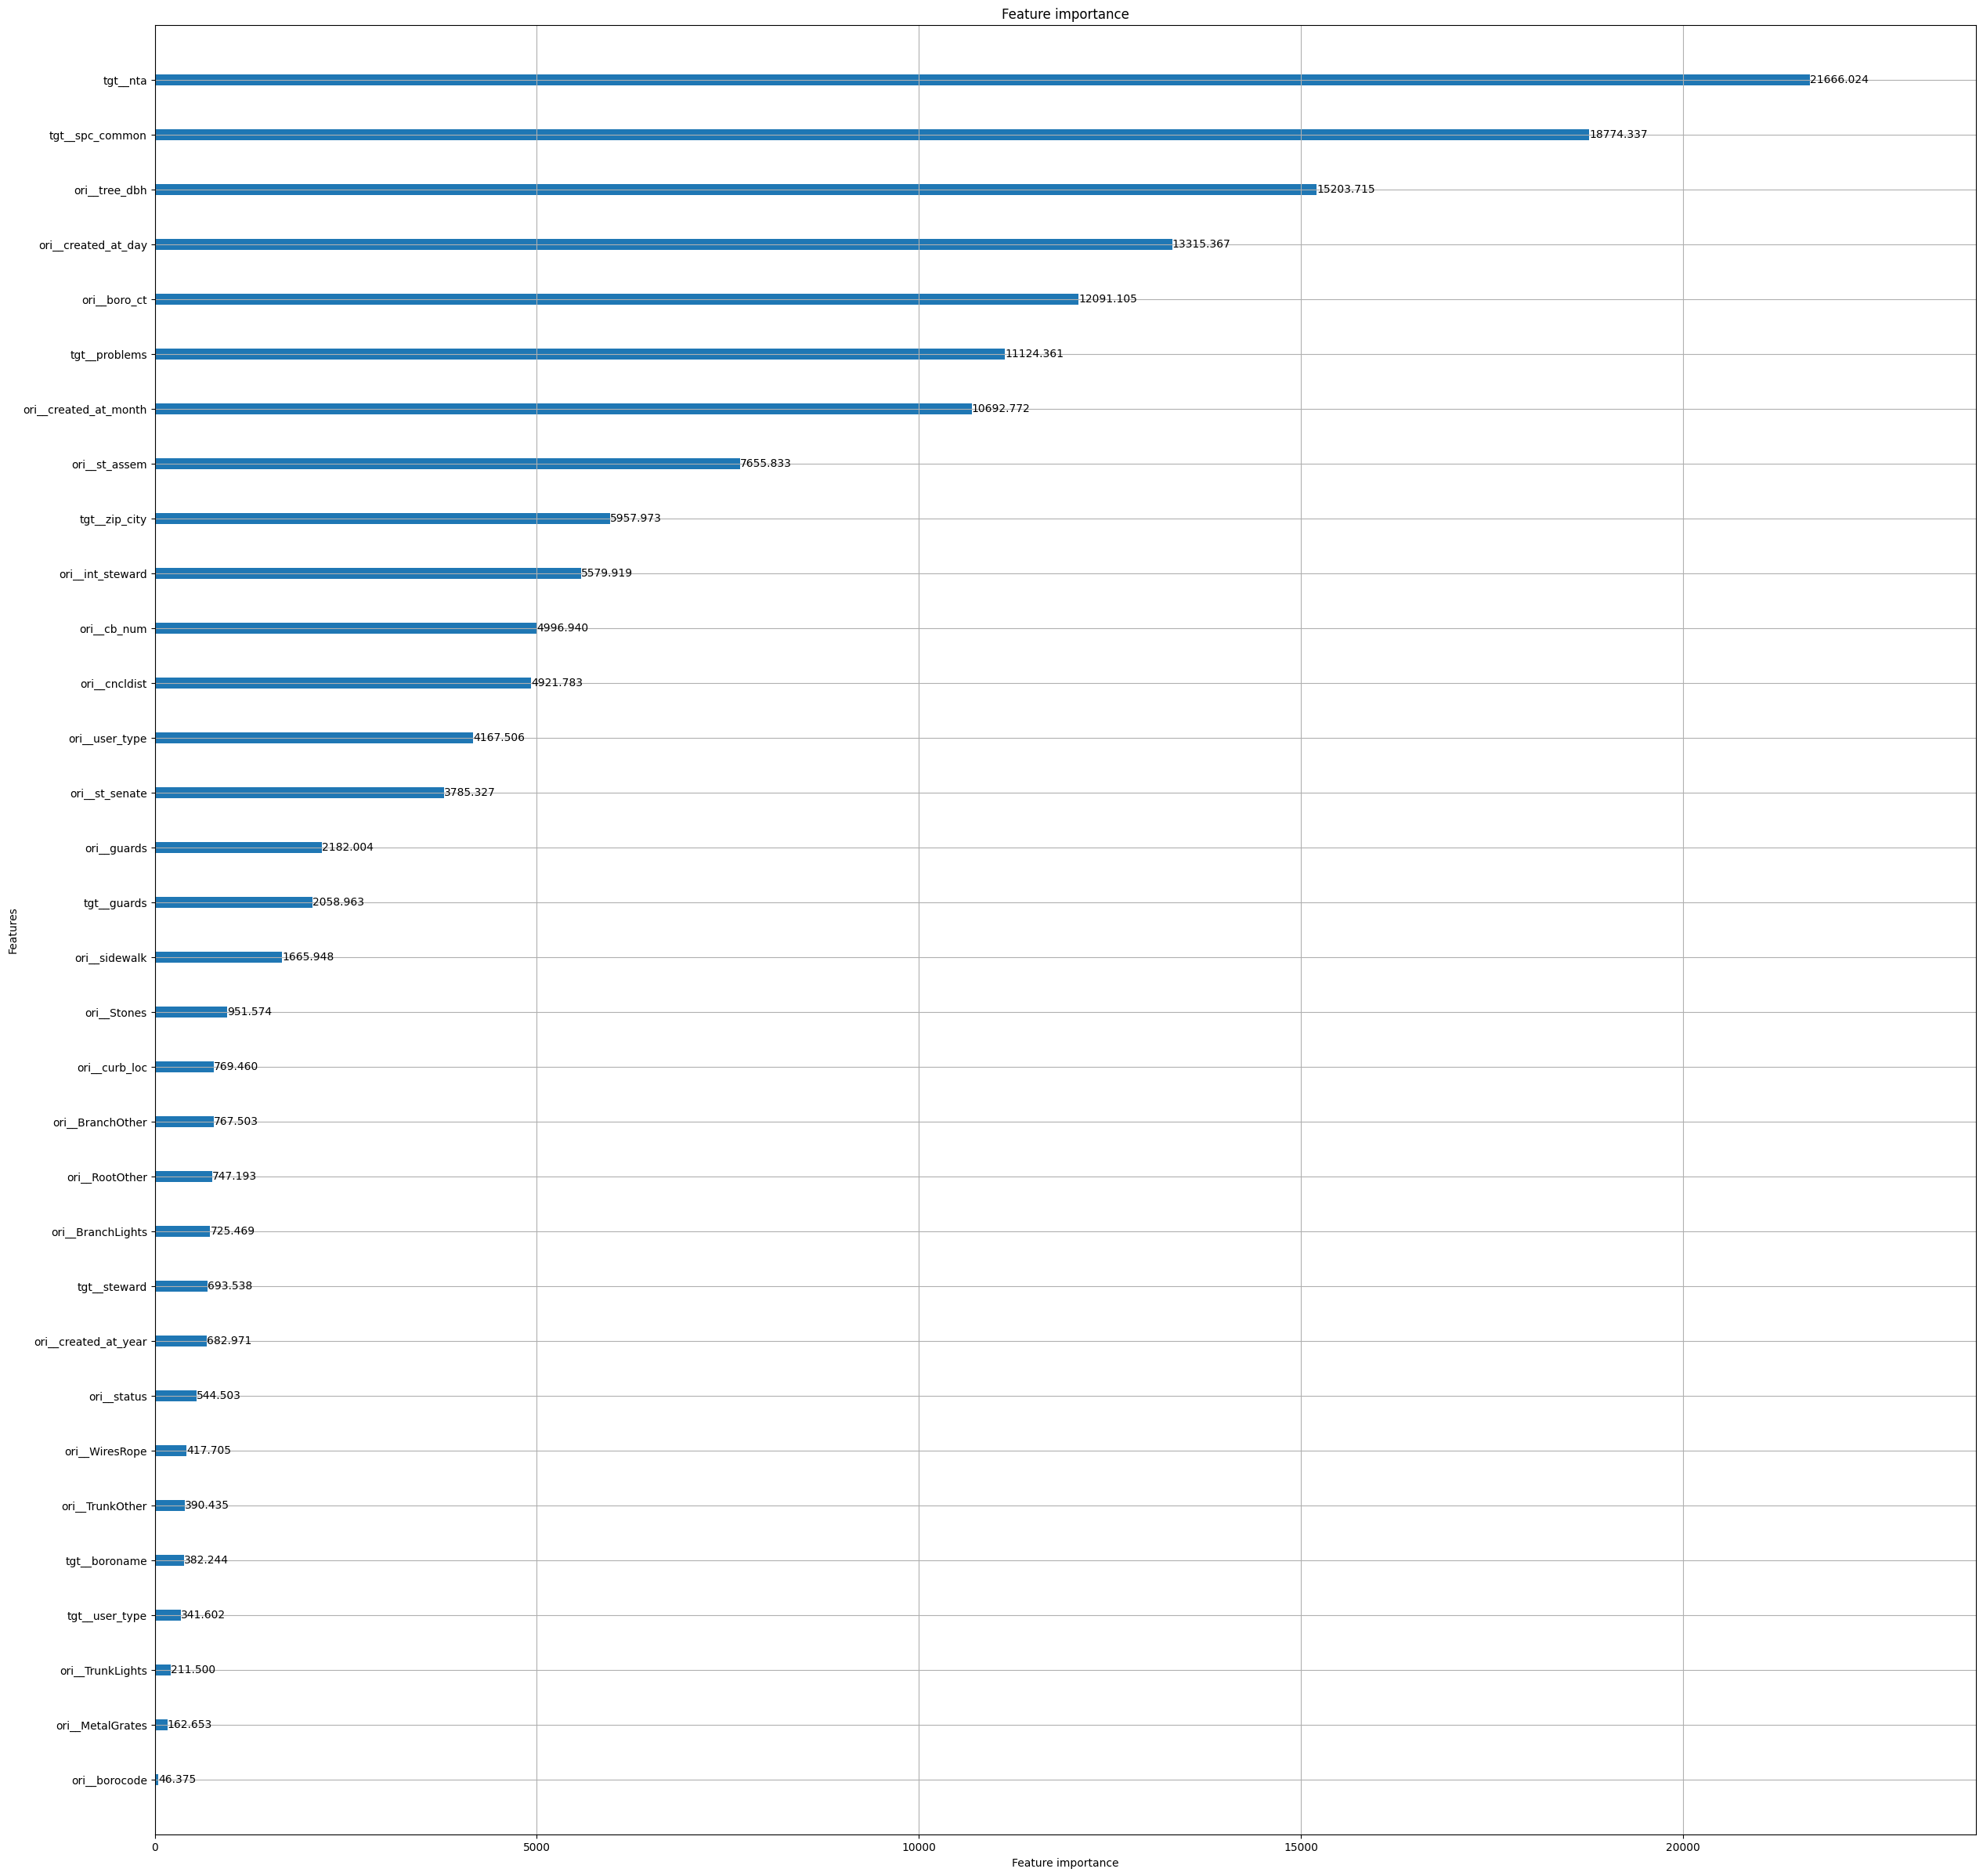

In [17]:
lgb.plot_importance(gbm,importance_type='gain')
plt.rcParams["figure.figsize"] = [30,30.0]

plt.show()

In [107]:
models[1].booster_.trees_to_dataframe().sample(5)

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
17338,284,6,284-S29,284-L29,284-L30,284-S28,ori__boro_ct,19.346300,5013003.5,<=,left,None,0.007886,12.972800,63
2843,46,10,46-L11,None,None,46-S27,None,NaN,None,None,None,None,-0.031250,40.447776,43
14609,239,8,239-S27,239-L13,239-S28,239-S26,ori__cb_num,20.083500,406.5,<=,left,None,-0.002276,306.567000,990
1803,29,8,29-S10,29-L9,29-L11,29-S9,ori__guards,52.987099,1,==,right,NaN,-0.021209,133.466000,306
13012,213,9,213-S16,213-L16,213-S18,213-S15,ori__st_assem,9.217530,32.5,<=,left,None,0.023176,110.961000,197


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

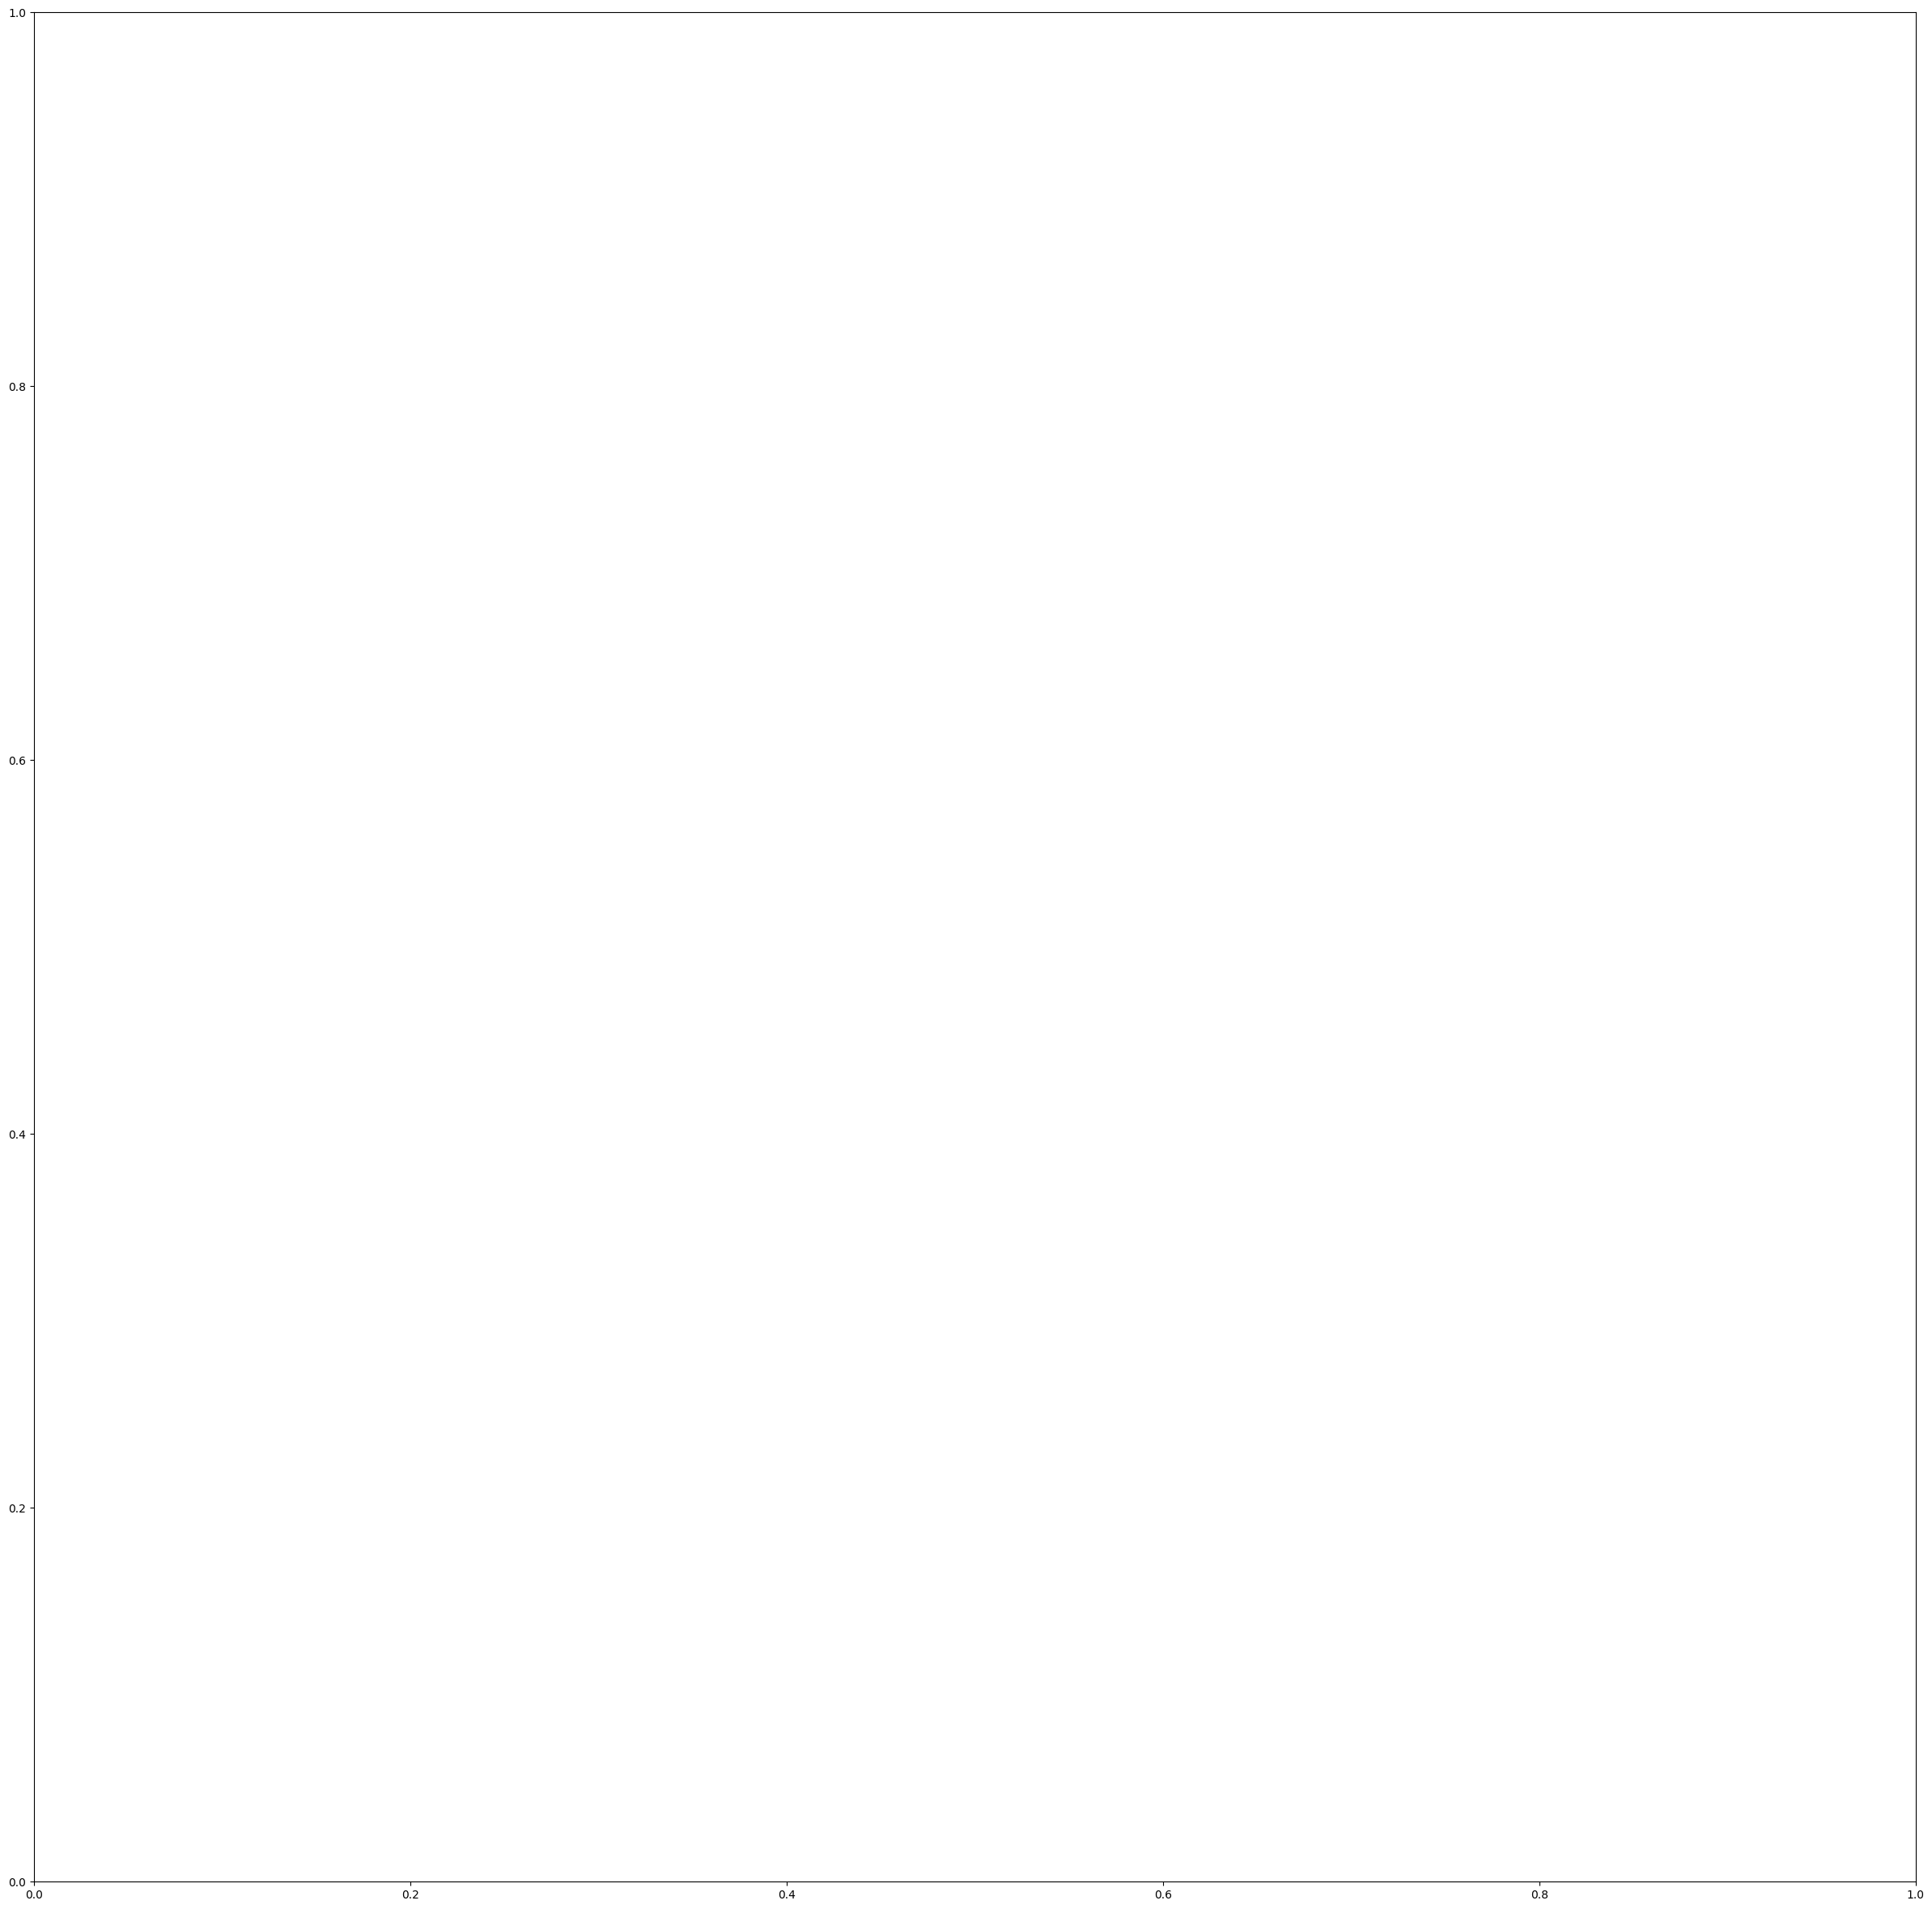

In [108]:
lgb.plot_tree(models[1],show_info=['leaf_count','split_gain','internal_value'], tree_index=11);

In [ ]:
import dtreeviz

model = models[1]
viz = dtreeviz.model(model,
               train_feat_df,
               train_date['health'],
               target_name = 'health',
               feature_names = train_feat_df.columns,
              tree_index = 100)

viz

ValueError: dtreeviz does not support NaN (see column(s) ori__int_steward, ori__guards)

In [ ]:
viz_model = dtreeviz.model(model,tree_index=1,
                        X_train=train_feat_df,y_train=train_date['health'],
                        feature_names=train_feat_df.columns,
                        target_name='health',class_names=["0","1",'3'])

ValueError: dtreeviz does not support NaN (see column(s) ori__int_steward, ori__guards)

In [ ]:
train_feat_df.dtypes


ori__tree_dbh             float32
ori__borocode             float32
ori__boro_ct              float32
ori__cb_num               float32
ori__st_senate            float32
ori__st_assem             float32
ori__cncldist             float32
ori__created_at_year      float32
ori__created_at_month     float32
ori__created_at_day       float32
ori__int_steward          float32
ori__curb_loc            category
ori__guards              category
ori__sidewalk            category
ori__user_type           category
ori__Stones              category
ori__BranchLights        category
ori__BranchOther         category
ori__RootOther           category
ori__TrunkOther          category
ori__WiresRope           category
ori__MetalGrates         category
ori__TrunkLights         category
tgt__curb_loc             float64
tgt__steward              float64
tgt__guards               float64
tgt__sidewalk             float64
tgt__user_type            float64
tgt__problems             float64
tgt__spc_commo

In [ ]:
mr2_numeric = train_date['steward'].cat.codes

AttributeError: Can only use .cat accessor with a 'category' dtype

In [54]:
# inference
pred = np.array([model.predict_proba(test_feat_df) for model in models])
pred = np.mean(pred, axis=0)
pred_classes = np.argmax(pred, axis=1)  # 各サンプルにおいて確率が最も高いクラスを選択
# 3値分類に変更
pred_classes = pred_classes.astype(int)

# submission
sub_df["health"] = pred_classes
sub_df.to_csv("submission.csv", index=False, header=False)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.1 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.1 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.1 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] learning_rate is set=0.05, eta=0.1 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will 